In [1]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from lambeq import AtomicType, IQPAnsatz, NumpyModel, BinaryCrossEntropyLoss, QuantumTrainer, SPSAOptimizer, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import en_core_web_trf
n, s = Ty('n'), Ty('s')
# nlp = en_core_web_trf.load()
nlp = spacy.load("ja_ginza")

c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
sentence = '俺は人を辞めるぞ、ジョジョ！'
doc = nlp(sentence)
displacy.serve(doc, style='dep', port=5001)
# 文頭を大文字、文末にピリオド をちゃんとやると正確になりやすいかも

c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\spacy\displacy\__init__.py:106: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5001 ...

Shutting down server on port 5001.


In [ ]:
def dependency_df(doc):
    
    doc = nlp(sentence)
    df = pd.DataFrame(columns=['token','token_num', 'dependency', 'token_head', 'token_head_num'])

    for token in doc:
        df = pd.concat([df, pd.DataFrame([{
            'token': token.text,
            'token_num': token.i,
            'dependency': token.dep_,
            'token_head': token.head.text,
            'token_head_num': token.head.i
        }])], ignore_index=True)
    
    
    return df

In [5]:
import pandas as pd

def dock_adjacent_by_head(df):
    """
    隣接していて token_head_num が同じ行群をまとめる。
    - df は少なくとも ['token','token_num','dependency','token_head','token_head_num'] を含むこと。
    - 位置（行順）は df の現在の順序で扱う。処理後に token_num を 0..N-1 で再付番する。
    """
    # 作業用に位置順にして index を付ける
    df = df.reset_index(drop=True).copy()
    n = len(df)
    i = 0
    groups = []  # 各グループは dict {rows: [pos0, pos1,...], orig_token_nums: [...], head_num_orig: int, head_text_orig: str}
    
    while i < n:
        head_num = int(df.loc[i, 'token_head_num'])
        group_rows = [i]
        j = i + 1
        # 連続する限り同じ head_num のものをグループにする
        while j < n and int(df.loc[j, 'token_head_num']) == head_num:
            group_rows.append(j)
            j += 1
        # 保存
        orig_token_nums = [int(df.loc[r, 'token_num']) for r in group_rows]
        groups.append({
            'rows': group_rows,
            'orig_token_nums': orig_token_nums,
            'head_num_orig': head_num,
            'head_text_orig': df.loc[i, 'token_head']  # 同じ head_num を参照しているので任意の行の token_head でよい
        })
        i = j
    
    # 各グループで token を結合。dependency はグループの最初の行の dependency を採用
    merged = []
    for g in groups:
        rows = g['rows']
        tokens = [str(df.loc[r, 'token']) for r in rows]
        merged_token = ''.join(tokens)  # 単純連結（必要ならここでスペースなどのルールを入れる）
        dependency = df.loc[rows[0], 'dependency']
        # head の参照先は groups の head_num_orig（元の token_num）なので後で新しい token_num にマップする
        merged.append({
            'token': merged_token,
            'orig_token_nums': g['orig_token_nums'],
            'dependency': dependency,
            'head_num_orig': g['head_num_orig'],
            # token_head は一旦 head の元の文字列を入れておく（後で更新）
            'token_head_orig': g['head_text_orig']
        })
    
    # 新しい token_num を付与（0..）
    for new_idx, m in enumerate(merged):
        m['token_num_new'] = new_idx
    
    # マッピング：元の token_num -> new token index & new token text
    orignum_to_newidx = {}
    orignum_to_newtoken = {}
    for m in merged:
        new_idx = m['token_num_new']
        for orig in m['orig_token_nums']:
            orignum_to_newidx[orig] = new_idx
            orignum_to_newtoken[orig] = m['token']
    
    # 最終行を作る：token_head_num, token_head を新しい値に置換
    final_rows = []
    for m in merged:
        # 元の head_num が self-reference（例えば root が自身を参照している）や
        # 他のトークンを参照している場合がある。
        head_orig = int(m['head_num_orig'])
        # もし head_orig がマッピングにあるなら新しいインデックスに変換
        if head_orig in orignum_to_newidx:
            new_head_num = orignum_to_newidx[head_orig]
            new_head_text = orignum_to_newtoken[head_orig]
        else:
            # 参照先がデータ外（稀）なら -1 を入れる or 元の値をそのまま残す（ここでは元のを採る）
            new_head_num = head_orig
            new_head_text = m['token_head_orig']
        
        final_rows.append({
            'token': m['token'],
            'token_num': m['token_num_new'],
            'dependency': m['dependency'],
            'token_head': new_head_text,
            'token_head_num': new_head_num
        })
    
    df_out = pd.DataFrame(final_rows, columns=['token','token_num','dependency','token_head','token_head_num'])
    return df_out


In [6]:
dep_df = dependency_df(doc)
adj_df = dock_adjacent_by_head(dep_df)
print(dep_df)
print(adj_df)

  token token_num dependency token_head token_head_num
0     俺         0      nsubj        辞める              4
1     は         1       case          俺              0
2     人         2        obj        辞める              4
3     を         3       case          人              2
4   辞める         4        acl       ジョジョ              7
5     ぞ         5       mark        辞める              4
6     、         6      punct        辞める              4
7  ジョジョ         7       ROOT       ジョジョ              7
8     ！         8      punct       ジョジョ              7
   token  token_num dependency token_head  token_head_num
0      俺          0      nsubj        辞める               4
1      は          1       case          俺               0
2      人          2        obj        辞める               4
3      を          3       case          人               2
4    辞める          4        acl      ジョジョ！               6
5     ぞ、          5       mark        辞める               4
6  ジョジョ！          6       ROOT      ジョジョ！   

In [ ]:
def build_pregroup_from_df(df):
    n, s = Ty('n'), Ty('s')
    cups = Id()

    # 空の Ty を入れる（ここで非参照問題はなし）
    df['type'] = [Ty() for _ in range(len(df))]

    for idx, row in df.iterrows():
        i = row['token_num']
        head_i = row['token_head_num']
        dep = row['dependency']

        # 現在の type を取り出す（コピー）
        ty = df.at[idx, 'type']

        # head の type を取り出す
        head_row = df.index[df['token_num'] == head_i][0]
        head_ty = df.at[head_row, 'type']

        # --- ROOT ---
        if dep == 'ROOT':
            new_ty = ty @ s
            df.at[idx, 'type'] = new_ty
            cups @= Id(s)
        
        # --- 非ROOT ---
        else:
            # 自分に n
            new_ty = ty @ n
            df.at[idx, 'type'] = new_ty

            # head に n.r または n.l を与える
            if i < head_i:
                new_head_ty = head_ty @ n.r
                df.at[head_row, 'type'] = new_head_ty
                cups @= Cup(n, n.r)

            elif i > head_i:
                new_head_ty = head_ty @ n.l
                df.at[head_row, 'type'] = new_head_ty
                cups @= Cup(n.l, n)

    return cups, df

In [22]:
cups, dep_with_types_df = build_pregroup_from_df(adj_df)
print(dep_with_types_df)
print(dep_with_types_df['type'].tolist())
print(cups)

   token  token_num dependency token_head  token_head_num  \
0      俺          0      nsubj        辞める               4   
1      は          1       case          俺               0   
2      人          2        obj        辞める               4   
3      を          3       case          人               2   
4    辞める          4        acl      ジョジョ！               6   
5     ぞ、          5       mark        辞める               4   
6  ジョジョ！          6       ROOT      ジョジョ！               6   

                                 type  
0                    (((n)), ((n.l)))  
1                             (((n)))  
2                    (((n)), ((n.l)))  
3                             (((n)))  
4  (((n.r)), ((n.r)), ((n)), ((n.l)))  
5                             (((n)))  
6                    (((n.r)), ((s)))  
[Ty(n) @ Ty(n).l, Ty(n), Ty(n) @ Ty(n).l, Ty(n), Ty(n).r @ Ty(n).r @ Ty(n) @ Ty(n).l, Ty(n), Ty(n).r @ Ty(s)]
|Ty() @ [CUP; Ty(n) @ Ty(n).r -> Ty()] @ Ty(n).l @ Ty(n) @ Ty(n) @ Ty(n).r @ Ty(n

In [23]:
def assign_words(df):
    Words = []
    for idx, row in df.iterrows():
        word = row['token']
        ty = row['type']
        Words.append(Word(word, ty))
    
    return Words

In [24]:
Words = assign_words(dep_with_types_df)
print(Words)

[Word(俺, ('Ty(n) @ Ty(n).l', {'0'})), Word(は, ('Ty(n)', {'0'})), Word(人, ('Ty(n) @ Ty(n).l', {'0'})), Word(を, ('Ty(n)', {'0'})), Word(辞める, ('Ty(n).r @ Ty(n).r @ Ty(n) @ Ty(n).l', {'0'})), Word(ぞ、, ('Ty(n)', {'0'})), Word(ジョジョ！, ('Ty(n).r @ Ty(s)', {'0'}))]


In [27]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

# 日本語フォントを設定
font_path = "C:\\Windows\\Fonts\\meiryo.ttc" 
jp_font = fm.FontProperties(fname=font_path) 
# matplotlibにフォントを設定
rcParams['font.family'] = jp_font.get_name()

# diagram作成
def create_diagram(sentence):
    doc = nlp(sentence)
    df = dependency_df(doc)
    cleaned_df = dock_adjacent_by_head(df)
    cups, dep_with_types_df = build_pregroup_from_df(cleaned_df)
    n, s = Ty('n'), Ty('s')
    types = Ty()
    
    word = assign_words(dep_with_types_df)
    
    diagram = Id().tensor(*word)
    
    for type in dep_with_types_df['type']:
        types @= type
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
      
    # --- 描画設定 ---
    fig = plt.figure(figsize=(10, 8))  # ← 全体スケールを上げる
    diagram.draw(
        figsize=(30, 10),     # 図の大きさ
        fontsize=10,         # テキストサイズ
        draw_types=True,     # 型を表示（不要ならFalse）
        color="black"        # 線の色（任意）
    )
    
           
    return diagram

<Figure size 1000x800 with 0 Axes>

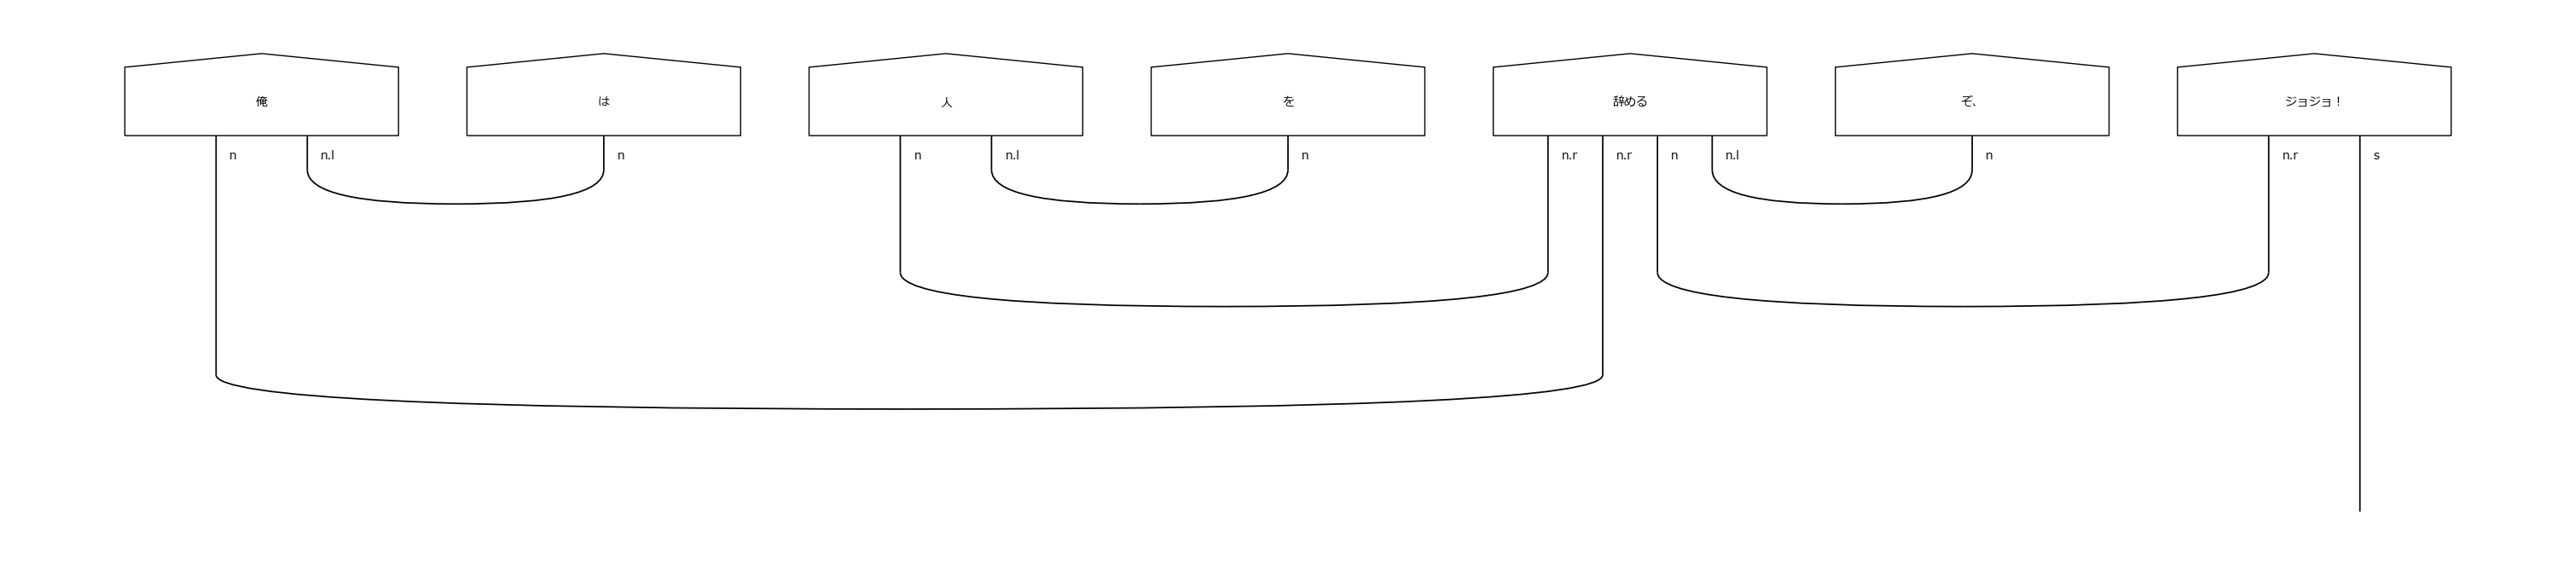

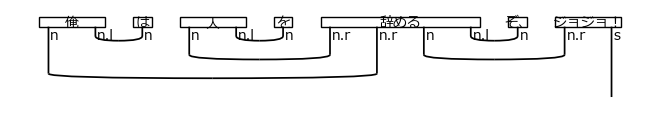

In [28]:
diagram = create_diagram(sentence)
draw(diagram)